In [2]:
import scanpy as sc
import pandas as pd
import os
import fast_matrix_market
import polars as pl
import scipy as sp


In [73]:
# Get folders in droplet
folders = os.listdir("droplet")
adata = []
for folder in folders[0:10]:
    channel = folder.split("-")[1]
    tissue = folder.split("-")[0]
    path = f"droplet/{folder}/"
    adata_small = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True)
    adata_small.obs["channel"] = channel
    adata_small.obs["tissue"] = tissue
    if folder == folders[0]:
        adata = adata_small
    else:
        adata = adata.concatenate(adata_small)
    print(f"Loaded {folder}")
adata

/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_29175/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)


Loaded Thymus-10X_P7_11
Loaded Tongue-10X_P7_10


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_29175/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)


Loaded Marrow-10X_P7_2
Loaded Bladder-10X_P4_3


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_29175/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)
/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_29175/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is dep

Loaded Bladder-10X_P4_4


/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_29175/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)


Loaded Marrow-10X_P7_3


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_29175/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)


Loaded Kidney-10X_P4_6


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_29175/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)


Loaded Mammary-10X_P7_13


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_29175/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)


Loaded Liver-10X_P4_2


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/var/folders/j_/p91_tr691jdc7zfzyb36vj9c0000gn/T/ipykernel_29175/2185081098.py:14: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adata_small)


Loaded Mammary-10X_P7_12


AnnData object with n_obs × n_vars = 15819 × 23433
    obs: 'channel', 'tissue', 'batch'
    var: 'gene_ids'

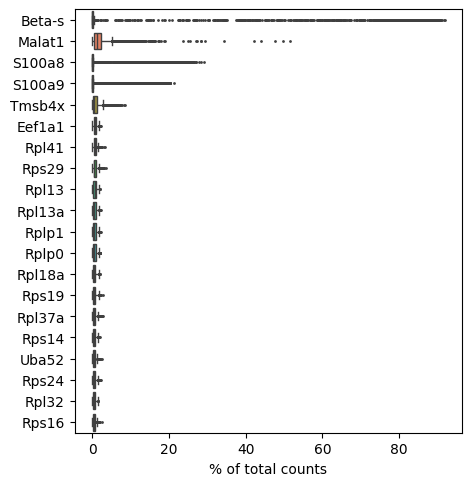

In [74]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [75]:
adata.var['mt'] = adata.var_names.str.startswith('Mt')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

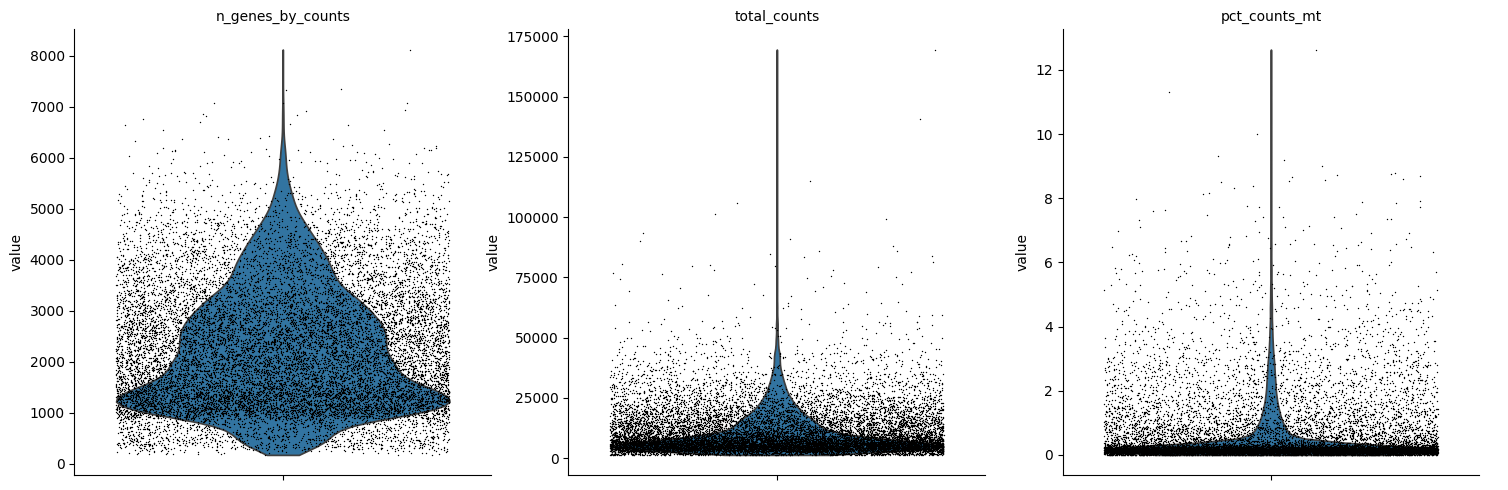

In [76]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [77]:
adata.var[adata.var["gene_ids"].apply(lambda x: x.startswith("Mt"))]

,gene_ids,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Mtap2,Mtap2,True,546,0.054871,96.548454,868.0
Mterfd2,Mterfd2,True,1440,0.100512,90.897023,1590.0
Mthfd1l,Mthfd1l,True,1142,0.094570,92.780833,1496.0
Mtrf1l,Mtrf1l,True,932,0.064669,94.108351,1023.0
Mtap7,Mtap7,True,2569,0.232063,83.760035,3671.0
...,...,...,...,...,...,...
Mtap7d3,Mtap7d3,True,187,0.014603,98.817877,231.0
Mtm1,Mtm1,True,774,0.053986,95.107150,854.0
Mtmr1,Mtmr1,True,1706,0.130097,89.215500,2058.0
Mtcp1,Mtcp1,True,1675,0.121499,89.411467,1922.0


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/scanpy/plotti

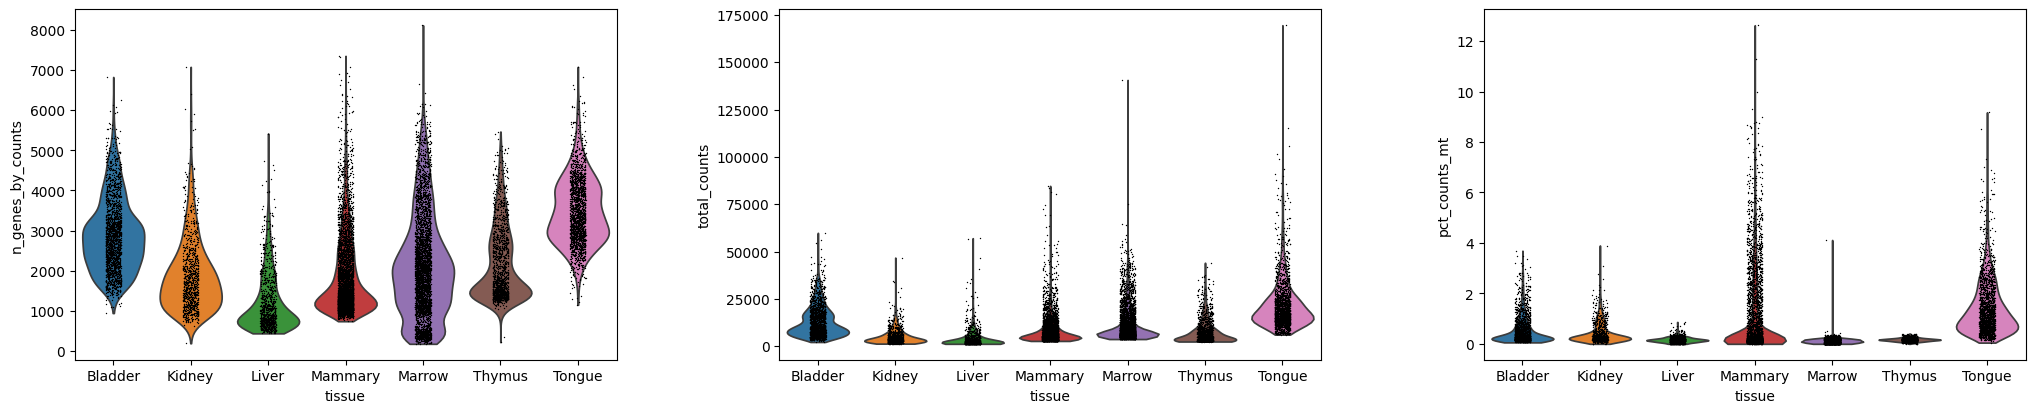

In [78]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
          multi_panel=True,groupby="tissue", )

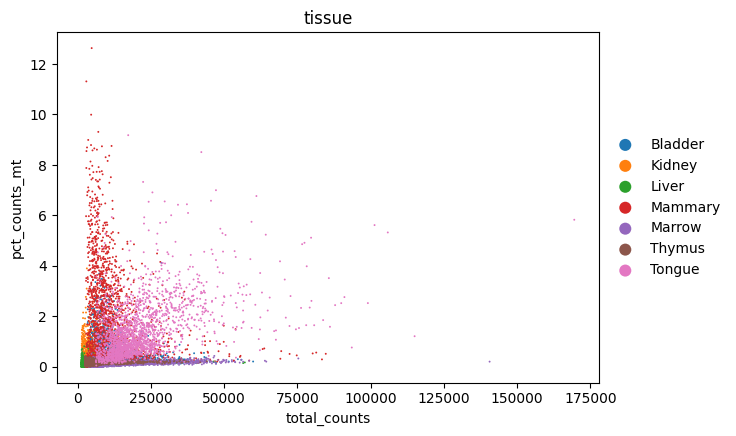

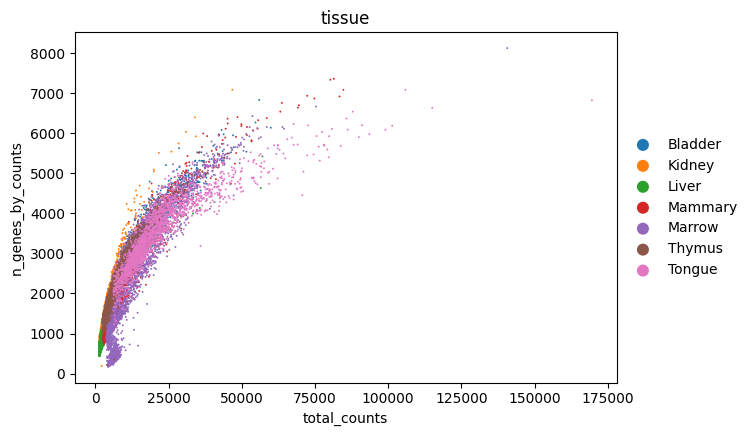

In [84]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color='tissue')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='tissue')

In [86]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/ireneroblesrebollo/anaconda3/envs/myscanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


ValueError: You need to run `tl.leiden` or `tl.louvain` to compute community labels, or specify `groups='an_existing_key'`